In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from data_utils import *

# Utils

In [2]:
# def plot_two_lines(x1, y1, x2, y2, lagend1, legend2):

#     # Create a figure and axis
#     fig, ax = plt.subplots(figsize=(20, 4))

#     # Plot the line
#     ax.plot(x1, y1, color = '#1f77b4') # blue
#     ax.plot(x2, y2, color = '#ff7f0e') # orange

#     # Set labels and title
#     plt.title('NYISO forecast')
#     ax.legend([lagend1, legend2])
#     ax.set(xlabel=None, ylabel='value', title=str(''))

#     # Rotate x-axis tick labels for better visibility
#     plt.xticks(rotation=45)
#     # Display the plot   

#     # fig.savefig('.png'.format(x))
#     fig.show()


# Load

## Read data

In [2]:
load = pd.read_pickle("load.pickle")
print(f'原始資料數量: {load.shape}')
load_NYC = load[(load['Date']>='2019-01-07 00:00:00')&(load['Date']<'2020-01-01 00:00:00')&(load['Zone']=='N.Y.C.')]
print(f'原始NYC資料數量: {load_NYC.shape}')
load_NYC.head(3)

原始資料數量: (1566192, 3)
原始NYC資料數量: (8606, 3)


,Date,Load,Zone
1172012,2019-01-07 00:00:00,4864.5,N.Y.C.
1172023,2019-01-07 01:00:00,4710.9,N.Y.C.
1172034,2019-01-07 02:00:00,4608.5,N.Y.C.


## Duplicates

In [4]:
df= load_NYC

# type2: 重複中有兩筆資料的取平均
duplicates_2 = df[df.duplicated(subset=['Date', 'Zone'])]
print(f'重複筆數: {duplicates_2.shape}')
df_drop = df.groupby(['Date', 'Zone'])['Load'].mean().reset_index()
print(f'平將後後資料數量: {df_drop.shape}')

load_drop = df_drop

重複筆數: (48, 3)
平將後後資料數量: (8558, 3)


## NA

In [5]:
df = load_drop

print(f'目前資料數量: {df.shape}')
df_all_time = merge_all_time(df)
print(f'補上所有時間後資料數量: {df_all_time.shape}')

# 驗算
hours_df = pd.DataFrame({'Date': pd.date_range(start = df['Date'].min(), end = df['Date'].max(), freq = '1H') })
print(f'驗算 365*24: {(365-6)*24}')

load_cleaned_NYC = df_all_time

目前資料數量: (8558, 3)
補上所有時間後資料數量: (8616, 3)
驗算 365*24: 8616


# loadfrcst

## Read data

In [6]:
loadfrcst = pd.read_pickle("loadfrcst.pickle")
print(f'原始資料數量: {loadfrcst.shape}')
loadfrcst_NYC = loadfrcst[(loadfrcst['Date']>='2019-01-07 00:00:00')&(loadfrcst['Date']<'2020-01-01 00:00:00')&(loadfrcst['Zone']=='N.Y.C.')]
print(f'原始NYC資料數量: {loadfrcst_NYC.shape}')
loadfrcst_NYC.head(3)

原始資料數量: (1737504, 3)
原始NYC資料數量: (8616, 3)


,Date,Load,Zone
910940,2019-01-07 00:00:00,4760,N.Y.C.
910952,2019-01-07 01:00:00,4579,N.Y.C.
910964,2019-01-07 02:00:00,4467,N.Y.C.


## Duplicates

In [7]:
df = loadfrcst_NYC

# type2: 重複中有兩筆資料的取平均
print(f'刪除前資料數量: {df.shape}')
duplicates_2 = df[df.duplicated(subset=['Date', 'Zone'])]
print(f'重複筆數: {duplicates_2.shape}')
df_drop = df.groupby(['Date', 'Zone'])['Load'].mean().reset_index()
print(f'刪除後資料數量: {df_drop.shape}')

load_drop = df_drop

刪除前資料數量: (8616, 3)
重複筆數: (1, 3)
刪除後資料數量: (8615, 3)


## NA

In [8]:
df = load_drop

print(f'目前資料數量: {df.shape}')
df_all_time = merge_all_time(df)
print(f'補上所有時間後資料數量: {df_all_time.shape}')

# 驗算
hours_df = pd.DataFrame({'Date': pd.date_range(start = df['Date'].min(), end = df['Date'].max(), freq = '1H') })
print(f'驗算 365*24: {(365-6)*24}')

loadfrcst_cleaned_NYC = df_all_time

目前資料數量: (8615, 3)
補上所有時間後資料數量: (8616, 3)
驗算 365*24: 8616


# my prediction

In [9]:
# Results
folder = '/home/hchuang/Documents/UQ-DL/SSSD/src/results/NYISO_all_stdd/T200_beta00.0001_betaT0.02/50k_test'
file_path = os.path.join(folder, 'mask0.npy')
mask = np.load(file_path)

file_path = os.path.join(folder, 'imputation0.npy')
imputations = np.load(file_path)

file_path = os.path.join(folder, 'original0.npy')
originals = np.load(file_path)

# Original scale dataset
folder = '/home/hchuang/Documents/UQ-DL/SSSD/src/datasets/NYISO/'
file_path = os.path.join(folder, 'load_array_all_test.npy')
load_array_test = np.load(file_path)

mean = np.mean(load_array_test, axis = 1).reshape(load_array_test.shape[0], 1, 11)
std = np.std(load_array_test, axis = 1).reshape(load_array_test.shape[0], 1, 11)

mean = np.einsum('ijk->ikj',mean)
std = np.einsum('ijk->ikj',std)

imputations_org_sca = (imputations*std+mean)
originals_org_sca = (originals*std+mean)

In [10]:
# convert from numpy to dataframe
ls = []
for x in range(len(imputations_org_sca)) : 
    ls.append(pd.Series(imputations_org_sca[x][8][144:168])) # 8 是 NYC

pred_series = pd.concat(ls).reset_index(drop=True)

load_pred_NYC = pd.DataFrame(data = {'Date': loadfrcst_cleaned_NYC['Date'],
                                  'Zone': loadfrcst_cleaned_NYC['Zone'],
                                  'Load': pred_series})

# MAPE

## Load vs loadfrst

In [11]:
y_hat = loadfrcst_cleaned_NYC['Load'].reset_index(drop=True)
y = load_cleaned_NYC['Load'].reset_index(drop=True)

# ignore na in loadfrcst
# mask = y_hat.isna()
# y = y[~y_hat.isna()]
# y_hat = y_hat[~y_hat.isna()]


print(f'Original MAPE: {np.mean(abs(y - y_hat)/y)*100}')

Original MAPE: 3.6606418374246865


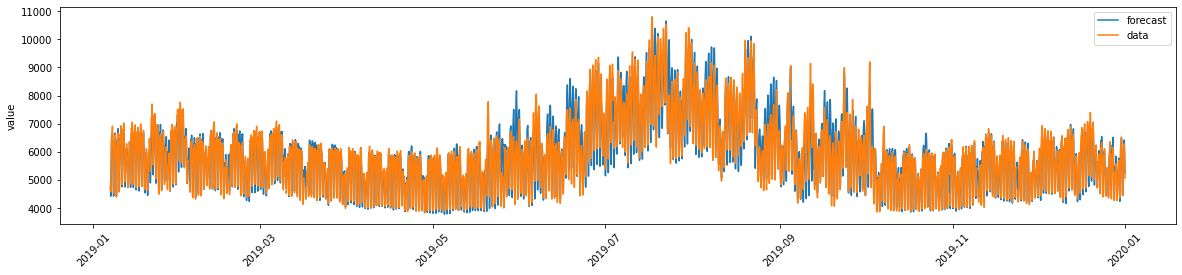

In [12]:
date = loadfrcst_cleaned_NYC['Date']

plot_two_lines(date, y_hat, date, y, 'forecast', 'data')

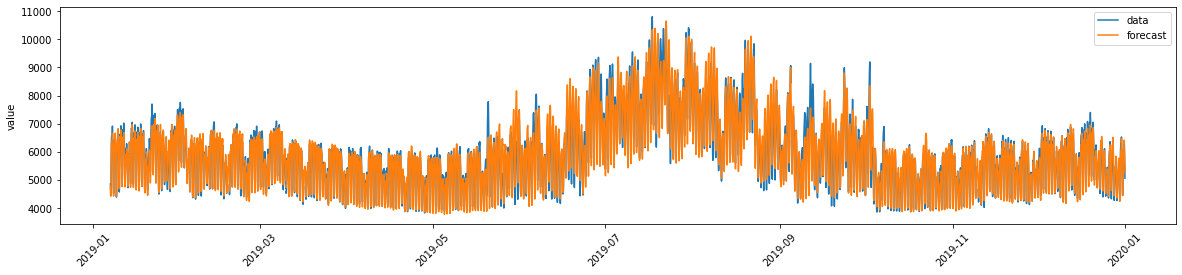

In [13]:
plot_two_lines(date, y,date, y_hat, 'data', 'forecast')

## Load vs my prediction

In [14]:
y_hat = load_pred_NYC['Load'].reset_index(drop=True)
y = load_cleaned_NYC['Load'].reset_index(drop=True)

print(f'Original MAPE: {np.mean(abs(y - y_hat)/y)*100}')

Original MAPE: 1.592382659727877


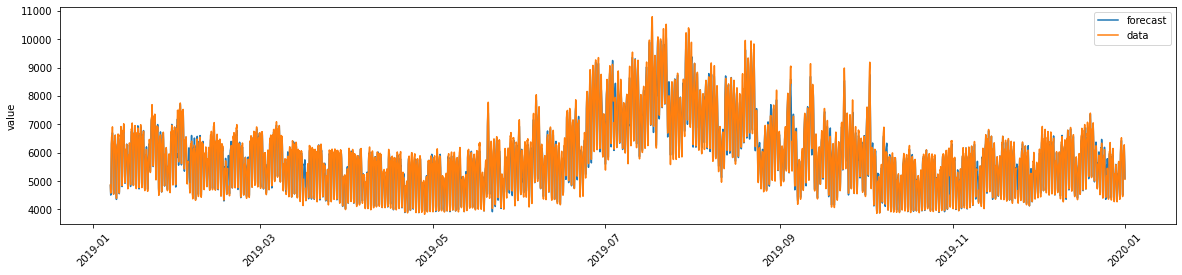

In [15]:
date = load_cleaned_NYC['Date']

plot_two_lines(date, y_hat, date, y, 'forecast', 'data')

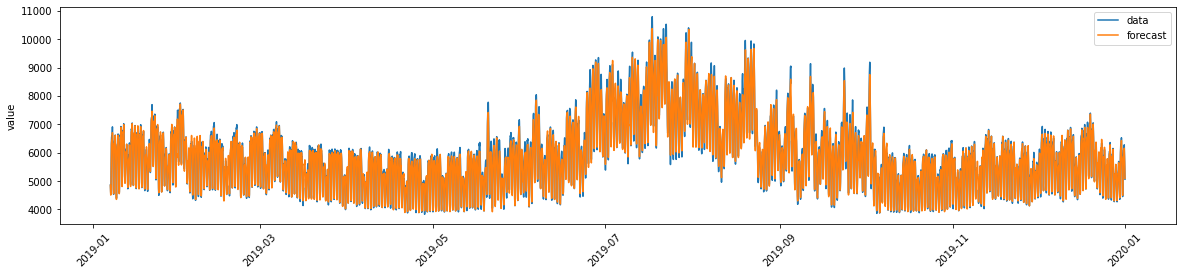

In [16]:
plot_two_lines(date, y,date, y_hat, 'data', 'forecast')